# Projeto final módulo 2

Para o projeto final do módulo 2, deverá ser feito um sistema de recomendação de livros baseada em popularidade.

## Os dados

Os dados em anexo na atividade são os seguintes:

* ratings.csv
    * Este conjunto de dados contém informações de avaliações dos usuários para com os livros, onde cada observação é uma avaliação de um usuário para com um livro.
* books.csv
    * Este conjunto de dados contém informações pertinentes ao livro, como o nome do livro, autores, etc.
* to_read.csv
    * Este conjunto de dados contém livros que os usuários salvaram para ler depois.

Para realizar o exercício só é necessário utilizar o arquivo `ratings.csv`, porém o arquivo `books.csv` é necessário para identificar qual o nome do livro que o usuário avaliou. O arquivo `to_read.csv` é opcional para avaliar se o usuário teve interesse em determinado livro.

## Análise

Antes de construir o sistema, deverá ser feita uma análise dos livros. 

* Primeiramente você deve remover os usuários que avaliaram menos de 3 livros, de modo a deixar apenas os usuários mais ativos do sistema, e trabalhar com este conjunto de dados a partir de então.
* Quantos livros existem?
* Quantos usuários existem?
* Qual a distribuição das avaliações dos livros? Existem notas estranhas no conjunto de dados?
* Qual a distribuição da quantidade de vezes cada livro é avaliado?
* Existe mais de uma avaliação para cada par de usuário e livro? Caso exista, explique qual método você vai utilizar para sumarizar em apenas uma nota.

## Sistemas de recomendação

Separe o conjunto de dados em 2 partes, sendo uma com 500 usuários (sorteados aleatoriamente) que tenham pelo menos 30 avaliações (conjunto de teste) e a outra com os demais (conjunto de treino). A interseção entre os dois conjuntos deve ser vazia.

### Sistema de recomendação baseado em popularidade

Após a análise deverá ser feito um sistema de recomendação simples, baseado em popularidade. Esse sistema de recomendação deve recomendar os 25 livros mais populares, onde a popularidade deve ser medida de acordo com a tendência central de avaliação (média, mediana, moda, etc.), com a justificativa da escolha da medida. Este sistema deve ser construído utilizando apenas os conjuntos de treino. 

Dado que o sistema recomenda os top 25 livros mais populares para cada usuário do conjunto de teste, avalie o desempenho das recomendações respondendo as seguintes perguntas: 

* Quantos usuários se interessaram por pelo menos um livro dos recomendados? 
    * Sugestão: utilize contagem da interseção entre o conjunto de livros recomendados e o conjunto de livros avaliados pelos usuários. Outra possibilidade é utilizar os livros que os usuários salvaram para ler, utilizando então a interseção entre o conjunto dos livros recomendados e o conjunto dos livros salvos para ler.
* Veja a distribuição de quantos livros os usuários se interessaram dos que foram recomendados.
    * Note que essa distribuição deve ir de 0 - 25, tendo em vista que só foram recomendados 25 livros, logo a interseção entre os livros que os usuários tiveram interesse e os recomendados não podem superar a contagem de 25.

##Análise

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import random

df_books = pd.read_csv('https://orionwinter.github.io/datasets/books.csv')
df_ratings = pd.read_csv('https://orionwinter.github.io/datasets/ratings.csv')
df_to_read = pd.read_csv('https://orionwinter.github.io/datasets/to_read.csv')

In [0]:
#df_ratings = df_ratings.assign(book_id2 = df_ratings['book_id'], user_id2 = df_ratings['user_id'])
df_books_ratings = df_ratings.set_index('book_id').join(df_books.set_index('book_id'),'book_id', 'left', lsuffix='_caller', rsuffix='_other')
df_books_ratings = df_books_ratings.reset_index()

In [0]:
df_user_votes_count = df_books_ratings.groupby('user_id', as_index=0).agg({'rating' : 'count'})

df_user_votes_count.columns = df_user_votes_count.columns.str.replace('rating','rating_count')

df_user_votes_count = df_user_votes_count.query('rating_count > 3')

In [0]:
df_books_ratings_without_not_active_users = df_books_ratings.set_index('user_id').join(df_user_votes_count.set_index('user_id'),'user_id','inner')
df_books_ratings_without_not_active_users = df_books_ratings_without_not_active_users.reset_index()

In [305]:
print('A quantidade de livros é {}'.format(df_books_ratings_without_not_active_users['book_id'].nunique()))

A quantidade de livros é 10000


In [306]:
print('A quantidade de usuários é {}'.format(df_books_ratings_without_not_active_users['user_id'].nunique()))

A quantidade de usuários é 39686


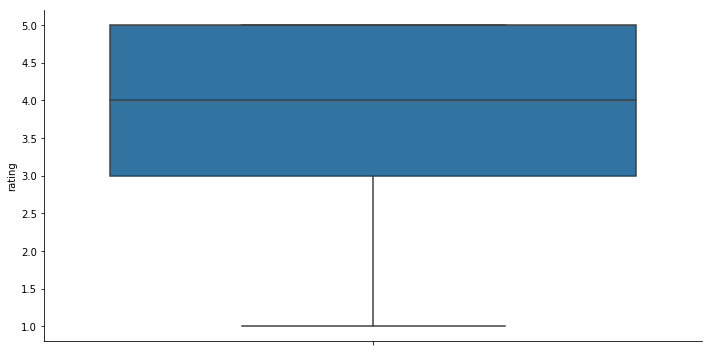

In [307]:
sns.catplot(y = "rating", 
            #x = "user_id2",
            data = df_books_ratings_without_not_active_users, 
            kind = "box",
            #inner = "quartiles",
            aspect = 2)

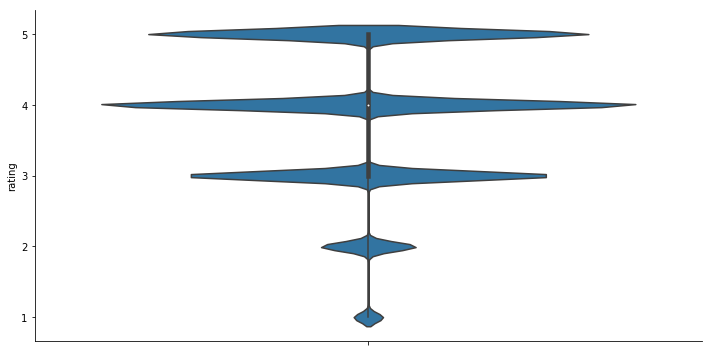

In [308]:
sns.catplot(y = "rating", 
            #y = "chuva",
            data = df_books_ratings_without_not_active_users, 
            kind = "violin",
            #inner = "quartiles",
            aspect = 2)

In [0]:
df_books_ratings_without_not_active_users = df_books_ratings_without_not_active_users.assign(rating2 = df_books_ratings_without_not_active_users['rating'])

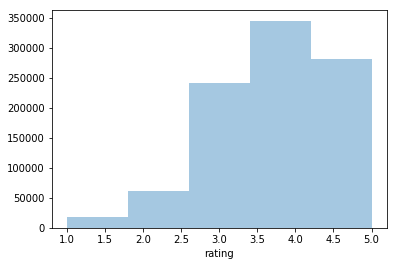

In [310]:
sns.distplot(df_books_ratings_without_not_active_users['rating'], kde=False, bins=5)

In [0]:
df_count_per_rating = df_books_ratings_without_not_active_users.groupby('rating', as_index=0).agg({'user_id' : 'count'})

A maioria das notas está entre 3 e 5 pontos (mais ou menos 90%).

In [0]:
df_count_per_book = df_books_ratings_without_not_active_users.groupby('book_id', as_index=0).agg({'rating' : 'count'})

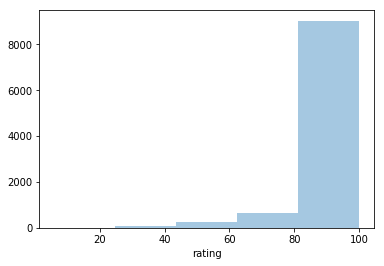

In [313]:
sns.distplot(df_count_per_book['rating'], kde=False, bins=5)

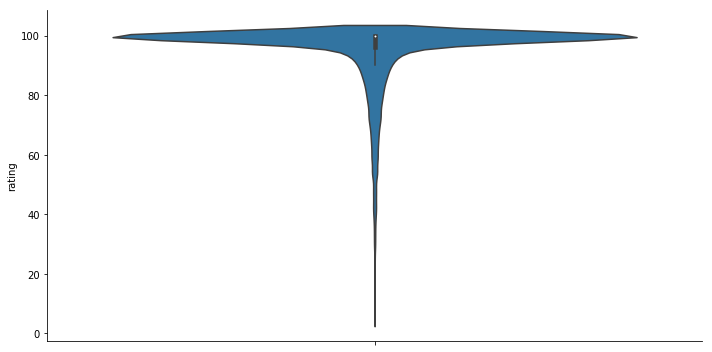

In [314]:
sns.catplot(y = "rating", 
            #y = "chuva",
            data = df_count_per_book, 
            kind = "violin",
            aspect = 2)

 A maioria dos livros foi avaliada por volta de 100 vezes.

In [315]:
df_count_per_book_user = df_books_ratings_without_not_active_users.groupby(['book_id','user_id']).agg({'rating' : 'count'})

df_count_per_book_user.query('rating > 1').count()

rating    2122
dtype: int64

Existem 2122 ocorrencias de avaliações do mesmo usuário ao mesmo livro. Uma maneira de fazer isso é pegando a avaliação de menor valor, já que não existe avaliação decimal na serie.

In [316]:
df_books_ratings_summarized = df_books_ratings_without_not_active_users[['user_id','book_id','rating','title']]

df_books_ratings_summarized = df_books_ratings_summarized.groupby(['user_id','book_id','title']).agg({'rating' : 'min'})

df_books_ratings_summarized.sort_values('user_id',ascending=False).head(1)

,,,rating
user_id,book_id,title,
53424,4214,Life of Pi,5


##Sistemas de Recomendação

In [0]:
df_books_ratings_summarized = df_books_ratings_summarized.reset_index()

In [0]:
df_users_rating_more_than_30 = df_user_votes_count.query('rating_count > 30')

df_users_rating_more_than_30.sort_values('rating_count',ascending=True)

df_unique_users_rating_more_than_30_votes = df_users_rating_more_than_30['user_id'].drop_duplicates().tolist()

random_500_users_from_the_more_than_30_votes = random.sample(df_unique_users_rating_more_than_30_votes, k=500)

other_users = df_user_votes_count['user_id'].drop_duplicates().tolist()

other_users = np.setdiff1d(other_users,random_500_users_from_the_more_than_30_votes).tolist() 

##Sistema de recomendação baseado em popularidade

In [319]:
filter1 = df_ratings['user_id'].isin(df_unique_users_rating_more_than_30_votes) 

df_ratings_from_the_most_active_users = df_ratings[filter1]

df_most_popular_movies = df_ratings_from_the_most_active_users.groupby('book_id').agg({'rating': [np.mean, np.median,lambda x: x.value_counts().index[0],'count','min','max']})

df_most_popular_movies.rename(columns=({'<lambda>':'mode'})).head(5)

rating                          
          mean median mode count min max
book_id                                 
1         4.24    4.0    5   100   1   5
2         4.21    4.5    5   100   1   5
3         3.09    3.0    5   100   1   5
4         4.46    5.0    5   100   1   5
5         3.89    4.0    5   100   1   5

No geral, os valores variam muito, por isso, faremos a opção por utilizar a mediana que neste caso melhor presenta o valor central da serie. A média e moda podem jogar os valores para baixo e para cima o que não representaria a opinião geral dos usuários.

In [0]:
df_most_popular_movies = df_ratings_from_the_most_active_users.groupby('book_id').agg({'rating': 'median'})

df_most_25_popular_movies = df_most_popular_movies.head(25).sort_values('rating',ascending=False)

Serão utilizados os livros marcados para ler pelos usuários da base inteira já que o objetivo é verificar a efetividade do algoritmo com a massa de usuários. Como pedido no enunciado, no resultado, será considerando somente o conjunto de treino.

In [321]:
df_to_read_x_recomentadion = df_to_read.join(df_most_25_popular_movies,'book_id', 'inner',lsuffix='_caller', rsuffix='_other')

filter2 = df_to_read_x_recomentadion['user_id'].isin(other_users)

df_to_read_x_recomendation_test_users = df_to_read_x_recomentadion[filter2]

df_to_read_x_recomendation_test_users['user_id'].nunique()

8827

A lista de recomendação atende a 8818 usuários. Considerando que existem 39686 na lista, vemos que a efetividade é baixa (~22%).

In [322]:
df_to_read_x_recomendation_test_users.reset_index()['book_id'].nunique()

25

In [323]:
df_to_read_x_recomendation_test_users.head(5)

,user_id,book_id,rating
600,61,4,5.0
930,103,4,5.0
1001,111,4,5.0
3349,315,4,5.0
3605,334,4,5.0


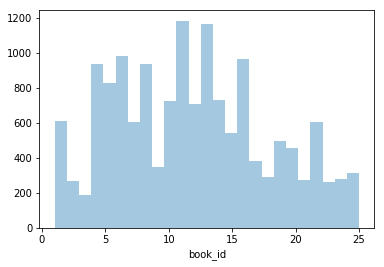

In [324]:
sns.distplot(df_to_read_x_recomendation_test_users['book_id'], kde=False, bins=25)

Tendo em vista que temos 36836 usuaários e que a adesão de recomentação de livros varia entre pouco menos de 200 usuários é um por volta de 1200, logo, vemos que um sistema de recomendação deste tipo não é efetivo já que não consegue abranger todos os usuários, obviamente, nos baseando nos dados existentes. 